# Supervised learning in Pytorch
Supervised learning is a type of machine learning problem a target quantity has to be infered from a set of input samples.
Classical inference tasks are regression, where a continuous target quantities has to be infered, and classification, where a discrete target is to be infered.
In this notebook we consider an image classification task.
Classically, image classification tasks are performed with careful filter engineering and feature extraction methods.
The features were then classified using classical classification algorithms, such as logistic regression or Support Vector Machine.
The classification algorithm was then tested against metrics such as mean squared error, accuracy, f1-score, ...

In 1990, the model `Lenet` was proposed.
`LeNet` directly maps input images to their label without manual filter design and is learnable end-to-end.
This enables the feature extraction pipeline and the classification algorithm to be trained jointly, without requiring engineering choices.

This model uses convolutional neural networks (CNN), a type of hidden layer which can be used to extract features on images regardless of their spatial location.
The features are extracted gradually with several repetitions of convolutional layers, non-linear activations and  pooling layers.
After the features have been extracted, the model uses fully connected layers to perform the final mapping to the image label.

The architectire is depicted below:
![Architecture](lenet.png)

Convolutional layers, pooling layers, activation functions and fully connected layers are all functions that are differentiable with respect to (wrt) their parameters.
The model is constructed so that the output can be compared to the expected output using loss functions which are differentiable wrt their input.
This allows `LeNet` to be trained using backpropagation, a gradient descent algorithm which uses the chain rule to calculate the derivative of a loss function wrt the trainable parameter.



## Objective
In this notebook, the objective is to obtain a testing performance of the `LeNet` model on the KMNIST dataset.
To achieve this, we will define our model and train it from scratch.

We will introduce the steps which must be implemented when working with a supervised learning pipeline:
- Data preparation
- Model architecture
- Training algorithm
- Testing algorithm


## Dataset

We use the KMNIST dataset which is a supervised learning classification task.
The dataset consists of 60,000 images of size 28x28 and 10 classes.


## Requirements

Basic knowledge in pytorch, follow this introduction if necessary: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch.nn import Module
from torch import nn
import torch.nn.functional as F
opts= {
    "batch_size":64,
    "loss_fun": nn.CrossEntropyLoss,
    "optimizer_fun":optim.SGD,
    "optimizer_opts":{"lr":0.01, "momentum":0.9}
}
print("torch=={}".format(torch.__version__))
print("torchvision=={}".format(torchvision.__version__))
print("numpy=={}".format(np.__version__))
print("matplotlib=={}".format(mpl.__version__))

torch==1.10.1+cu102
torchvision==0.11.2+cu102
numpy==1.20.2
matplotlib==3.5.1


# Overview

In this tutorial the goal is to define, train and test a convolutional neural network on a classification dataset.
We introduce the key steps required to train and test any deep neural network architecture.

Introduce the steps which must be implemented when working with a supervised learning pipeline:
- Data preparation
- Model architecture
- Training algorithm
- Testing algorithm


For demonstration purpose, we use a supervised learning task on the KMNIST dataset.
The dataset can be downloaded as shown below:

Training tensor shape: 60000 28 28
Number of classes: 10
Example images:


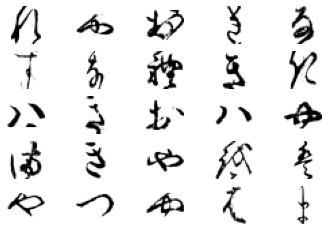

In [2]:
# Download and parse the dataset
# When working with images, the torchvision package provides useful tools to manipulate and convert image formats.
transform = transforms.Compose(
    [transforms.ToTensor()])

# Torchvision also distributes reference datasets represented in torch compatible objects
# We will save the downloaded dataset (~73MB) in a parent folder, in case we need it in another lab
trainset = torchvision.datasets.KMNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.KMNIST(root='../data', train=False, download=True, transform=transform)

# We can look at our data dimension and plot some example images
n_samples,h,w = trainset.data.shape
print("Training tensor shape:", n_samples, h, w)
print("Number of classes:",len(trainset.classes))
print("Example images:")

plt.figure()
for i in range(25):
    ax=plt.subplot(5,5,i+1)
    img = trainset.data[i]
    ax.imshow(img, cmap="Greys")
    ax.axis('off')
plt.savefig("KMNIST.png")
plt.show()

## Step 1: Data preparation

Once the dataset is downloaded, the first step is typically to cast the data into classes specifically design for model training.

Such classes are helpful to abstract batch-level operations such as shuffling, parsing, batch spliting, batch 
normalization.

In `torch`, such a class is called `DataLoader` and is implemented in.
[`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader)

- Task 1: Create `DataLoader` instances built on the training and testing datasets. The dataloader should be initialized such that it shuffles the input samples, and use a batch size of `64` samples.

In [3]:
# Task 1
trainloader = torch.utils.data.DataLoader(trainset, batch_size=opts["batch_size"], shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=opts["batch_size"], shuffle=True, num_workers=2)

## Step 2: Model definition

Once the dataset is downloaded and cast in the right data structure, we must define the model which will process the data batches.

In pytorch, models are implemented by inheriting the `nn.Module` class.
When implementing a new model in pytorch, one must define the different layers and activation functions and forward pass computation. The nice thing about using a deep learning toolbox is that the forward pass and the gradient computation of the most famous layer types are readily available.

For this step we will implement the LeNet neural network architecture.

- Task 2: Implement the LeNet architecture using the class skeleton provided below. The details of the model, can be found here: http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf. The main part of the class is defined for you and you are left with the implementation of the last dense layer which takes as input 84-dimensional features and outputs 10-dimensional target vectors.


Hint:
- All the required layer class are implemented in pytorch in the `nn` module.
- Functional for relu can be found in the `nn.functional` module.
- The useful classes are: 
    - nn.Linear
    - F.relu

In [4]:
""" Network definition
    The role of the Net class is to compute the forward pass of a batch of images.
    
    The __init__ function is called when the class is instanciated.
        It must contain the declaration of the different trainable and non trainable layers.
        The layers must be defined as attributes (fields) of the Net class.
        This function can take the network's hyper-parameters as arguments.
        Here we use a famous network so we can hard code the layer's sizes.
        The activation and pooling functions can be defined here or in the forward function.
    
    The forward function is called when we want a batch of images to pass through the network layers.
        It is where we describe the architecture of the network by chaining the layers together.
        It must take a batch as input, and output the network's prediction.
"""


# Task 2
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()
        # The images are black/white, i.e. only 1 channel is required as input to the first convolutional layer.
        # As is depicted on the image, the first layer outputs 6 channels.
        # The intermediate feature map size is 28, and we have image of size 28 in the input
        # (as opposed to 32 mentioned in the original architecture)
        # To get the correct size in the first intermediate feature map the kernel can be 5 samples wide
        # and the input image padded with 2 samples in each direction
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
                
        # At this stage, the network stops reducing the feature map sizes with pooling layers,
        # We aggregate all the remaining samples and continue with dense layers
        # How many samples are left at the input of the first dense layer ?
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        y = F.relu(self.conv1(x))
        # As mentioned in the paper, the subsampling operation keeps the maximum value in 2 x 2 patches of image.

        y = F.max_pool2d(y, (2, 2))
        y = F.relu(self.conv2(y))
        y = F.max_pool2d(y, (2, 2))
        
        # Aggregate (flatten) all the remaining extracted feature maps
        y = y.view(y.shape[0], -1)
        y = F.relu(self.fc1(y))
        y = F.relu(self.fc2(y))
        y = F.relu(self.fc3(y))
        return y
    
# Instantiation, (call the __init__ function of the class)
net = Net()


In [5]:
from operator import mul
from functools import reduce

l=nn.Conv2d(1, 6, 5, padding=2, bias=True)
params=[ll for ll in l.parameters()]
print("Number of parameter tensors:",len(params))
print("Kernel tensor shape:", params[0].shape)
print("Kernel number of parameters:",reduce(mul,params[0].shape))
try:
    print("Bias tensor shape:", params[1].shape)
except:
    pass

Number of parameter tensors: 2
Kernel tensor shape: torch.Size([6, 1, 5, 5])
Kernel number of parameters: 150
Bias tensor shape: torch.Size([6])


## Step 3: Training loop

Now the data object are created and the network architecture is implemented.
Before our network can be trained, we must define the optimization criterion, the type of optimizer we will use and finally, write the training algorithm.

The optimization criterion we use is the `CrossEntropyLoss` from the `torch.nn` module.
The optimizer we use is the stochastic gradient descent `SGD`from the `torch.optim` module.

- Task 3: Your task is now to write the training loop for our neural network architecture.

Hint:
The training procedure may be decomposed into the following steps:

- Forward pass
- Loss evaluation
- Gradient computation
- Parameters update

In [6]:
# Instantiation of the loss function defined in the `opts` dictionary
criterion = opts["loss_fun"]()

# Instantiation of the optimizer with all the network's trainable parameters as arguments
optimizer = opts["optimizer_fun"](net.parameters(), **opts["optimizer_opts"])



# Task 3
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # We want the gradients of each batches to be calculated independently. 
        # We discard previously computed gradients by setting them to 0
        optimizer.zero_grad()

        ####
        # forward + evaluation + backward + optimize
        ####
        
        # During the forward pass, pytorch automatically accumulates the gradient of the output of each layer 
        # with respect to its input.
        outputs = net(inputs)
        
        # The loss can be evaluated by simply calling the criterion function with both the predicted and true labels
        loss = criterion(outputs, labels)
        
        # The final quantity required to run the update rule on the trainable parameters is the gradient of the loss
        # with respect to the parameters. The appropriate gradients must have been accumulated during the forward pass
        # and what this next step does is apply the chain rule.
        loss.backward()
        
        # Once the gradients are calculated, we can perform a step of the update rule using the optimizer object:
        optimizer.step()
        
        
        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0

print('Finished Training')


[1,   200] loss: 388.447
[1,   400] loss: 219.552
[1,   600] loss: 168.564
[1,   800] loss: 124.146
[2,   200] loss: 102.524
[2,   400] loss: 97.861
[2,   600] loss: 91.947
[2,   800] loss: 88.715
[3,   200] loss: 82.184
[3,   400] loss: 79.540
[3,   600] loss: 78.218
[3,   800] loss: 78.730
[4,   200] loss: 52.466
[4,   400] loss: 32.954
[4,   600] loss: 27.174
[4,   800] loss: 17.896
[5,   200] loss: 12.775
[5,   400] loss: 14.174
[5,   600] loss: 12.385
[5,   800] loss: 12.231
[6,   200] loss: 9.460
[6,   400] loss: 10.446
[6,   600] loss: 9.775
[6,   800] loss: 10.333
[7,   200] loss: 6.986
[7,   400] loss: 6.376
[7,   600] loss: 8.475
[7,   800] loss: 6.711
[8,   200] loss: 4.429
[8,   400] loss: 5.696
[8,   600] loss: 6.307
[8,   800] loss: 6.792
[9,   200] loss: 4.123
[9,   400] loss: 4.139
[9,   600] loss: 4.226
[9,   800] loss: 4.505
[10,   200] loss: 3.165
[10,   400] loss: 3.443
[10,   600] loss: 3.831
[10,   800] loss: 4.754
Finished Training


# Gradient computation in pytorch

<img src="./LeTweet.png" width="500">

Let us investigate the backward gradient pass a bit more.
You will find a detailed explaination of backpropagation in pytorch [here](https://amsword.medium.com/understanding-pytorchs-autograd-with-grad-fn-and-next-functions-b2c4836daa00)

## A simple example first

Let us go look at a simple example taken from [here](https://amsword.medium.com/understanding-pytorchs-autograd-with-grad-fn-and-next-functions-b2c4836daa00)

We define a simple differentiable operation:
- the element wise multiplication of two tensors (`z=x*y`)
- followed by the sum of the resulting elements (`l=z.sum()`).

The result tensor `l` has a `.grad_fn` attribute.
The `l.grad_fn` object has a next_functions attribute.
This will help us iterate backward on the computation graph, until we encounter the trainable weights (the leafs of the graph).

We would like to calculate the gradient of this operation wrt the two initial tensors.
- We first compute the gradients with a call to `.backward()`
- then we compute the gradients by iterating through the compute graph using the `grad_fn` attribute of the final tensor.

In [7]:
torch.manual_seed(6)
x = torch.randn(2, 1, requires_grad=True)
y = torch.randn(2, 1, requires_grad=True)
z = x * y
l = z.sum()
l.backward()
print("Gradient computed after the .backward() call:")
print(x.grad)
print(y.grad)
print()


torch.manual_seed(6)
x = torch.randn(2, 1, requires_grad=True)
y = torch.randn(2, 1, requires_grad=True)
z = x * y
l = z.sum()

dl = torch.tensor(1.)

back_sum = l.grad_fn
dz = back_sum(dl)
back_mul = back_sum.next_functions[0][0]
dx, dy = back_mul(dz)
back_x = back_mul.next_functions[0][0]
back_x(dx)

back_y = back_mul.next_functions[1][0]
back_y(dy)

print("Gradient computed after manual backprop on the compute graph:")
print(x.grad)
print(y.grad)

Gradient computed after the .backward() call:
tensor([[ 0.7185],
        [-0.6985]])
tensor([[-1.8744],
        [-0.9937]])

Gradient computed after manual backprop on the compute graph:
tensor([[ 0.7185],
        [-0.6985]], grad_fn=<CopyBackwards>)
tensor([[-1.8744],
        [-0.9937]], grad_fn=<CopyBackwards>)


We see that both approaches lead to the same gradients.

## A more systematic investigation

In [8]:
# We take the last inputs batch we encountered and run it through the network once again
outputs = net(inputs)

# We evaluate the loss 
loss = criterion(outputs, labels)

# The loss object contains a grad_fn attribute.
grad_fn = loss.grad_fn

# We write an recursive function to print the gradient computation functions we encounter.
# The functions named "AccumulateGrad" inform us that we have reached a Leaf node.
# When the leaf nodes are reached, the .grad attribute of the current tensor is ready to be populated with their gradient.
def print_back_fun(fun,i):
    if fun is None: 
        # Not sure why/when these None attributes occur
        pass
    
    elif fun.next_functions == (): 
        # When the list of next_functions is empty we reached a Leaf node, i.e. a parameter tensor
        print(i,";","Leaf",fun)
        
    else:
        # Print the current grad function and the depth of the recursion
        print(i,";", fun)
        # Iterate through the rest of the graph recursively, increase the depth of the recursion by 1
        list(map(lambda x: print_back_fun(x[0],i+1), fun.next_functions))


print_back_fun(grad_fn,0)

0 ; <NllLossBackward0 object at 0x7fce587ae520>
1 ; <LogSoftmaxBackward0 object at 0x7fce5884e400>
2 ; <ReluBackward0 object at 0x7fceec85caf0>
3 ; <AddmmBackward0 object at 0x7fce57fe94c0>
4 ; Leaf <AccumulateGrad object at 0x7fce5a9bdf40>
4 ; <ReluBackward0 object at 0x7fce5a9bda00>
5 ; <AddmmBackward0 object at 0x7fce57fe99d0>
6 ; Leaf <AccumulateGrad object at 0x7fce57fe93a0>
6 ; <ReluBackward0 object at 0x7fce57fe91c0>
7 ; <AddmmBackward0 object at 0x7fce57fb5fa0>
8 ; Leaf <AccumulateGrad object at 0x7fceec0143d0>
8 ; <ViewBackward0 object at 0x7fceec0143a0>
9 ; <MaxPool2DWithIndicesBackward0 object at 0x7fced47c1c70>
10 ; <ReluBackward0 object at 0x7fced47c1bb0>
11 ; <MkldnnConvolutionBackward0 object at 0x7fced50520a0>
12 ; <MaxPool2DWithIndicesBackward0 object at 0x7fced50523a0>
13 ; <ReluBackward0 object at 0x7fced5052760>
14 ; <MkldnnConvolutionBackward0 object at 0x7fced5052b20>
15 ; Leaf <AccumulateGrad object at 0x7fced5052eb0>
15 ; Leaf <AccumulateGrad object at 0x7fced50

We encounter 10 leaf nodes, which corresponds to the number of parameter tensors in our network:

In [9]:
the_params=[p.shape for p in net.parameters()]
print("Number of parameter tensors",len(the_params),":")
the_params

Number of parameter tensors 10 :


[torch.Size([6, 1, 5, 5]),
 torch.Size([6]),
 torch.Size([16, 6, 5, 5]),
 torch.Size([16]),
 torch.Size([120, 400]),
 torch.Size([120]),
 torch.Size([84, 120]),
 torch.Size([84]),
 torch.Size([10, 84]),
 torch.Size([10])]

 This means that, even before calling the `.backward()` function, the intermediate gradients are computed and stored during the forward pass.
The call to `.backward()` triggers the computation of the chain rule for each Leaf node (parameter tensor) of the computation graph we displayed above.


# Step 4: Testing algorithm

Now that our network has been trained, we can measure the performance on the held out test dataset.
The measure which we will use is the accuracy.

- Task 4: Write the code necessary to compute the accuracy on the held out test set.

Hint:
 - To avoid unnecessary computations, make sure that the gradient is not computed while the test samples pass through the network.
 - A probabilistic interpretation of the network's output is not required when computing the accuracy. All we need is the index of the largest output. To get the probabilistic interpretation you can use a softmax.


In [10]:
# Accuracy score
# Task 4
from datetime import datetime

total=0
correct=0
start_time = datetime.now()
print("with torch.no_grad()")
# To avoid the computation of the gradients during the forward pass,
# We use the torch.no_grad() environment
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        if total==0:
            print(outputs[-1])
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
elapsed=(datetime.now()-start_time).total_seconds()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("runtime: {:.3f} sec".format(elapsed))

with torch.no_grad()
tensor([14.6275,  0.0000,  0.0000,  0.0000,  2.1778,  4.4840,  4.0166,  2.7928,
         0.7524,  0.0000])
Accuracy of the network on the 10000 test images: 94 %
runtime: 0.856 sec


## with or without torch.no_grad() ?

In [11]:
print("without torch.no_grad()")

total=0
correct=0
start_time = datetime.now()
# To avoid the computation of the gradients during the forward pass,
# We use the torch.no_grad() environment
#with torch.no_grad():
for data in testloader:
    images, labels = data
    outputs = net(images)
    if total==0:
        print(outputs[-1])
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
elapsed=(datetime.now()-start_time).total_seconds()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("runtime: {:.3f} sec".format(elapsed))


without torch.no_grad()
tensor([ 0.0000,  4.5170,  8.9265,  0.0000,  1.5727,  0.0000, 17.4996,  1.6864,
         0.0000,  0.0000], grad_fn=<SelectBackward0>)
Accuracy of the network on the 10000 test images: 94 %
runtime: 0.816 sec


We see that when torch.no_grad() is used, the output tensors are not populated with the gradient functions `grad_fn`. This means that the gradients are not computed during the forward pass. The memory consumption of the forward pass is thus reduced. For large models you can also expect a gain in runtime.